In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [2]:
# Reading the Excel file to get sheet names
xls = pd.ExcelFile("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")
sheet_names = xls.sheet_names

# Reading the contents of the 'Information' 'Training_Data' and 'Test_Data' sheets
information_df = xls.parse("Information")
training_data_df = xls.parse("Training_Data")
test_data_df = xls.parse("Test_Data")

The `Information` sheet provides some details about the dataset:

- The dataset is multivariate.
- There are 403 instances.
- The area of application is education.
- The attributes are real-valued.
- There are 5 attributes.
- The dataset is used for classification tasks.

The dataset also provides the following attributes:

1. `STG`: The degree of study time for goal object materials.
2. `SCG`: The degree of repetition number of user for goal object materials.
3. `STR`: The degree of study time of user for related objects with goal object.
4. `LPR`: The exam performance of user for related objects with goal object.
5. `PEG`: The exam performance of user for goal object.
6. `UNS`: The knowledge level of user.

The class distribution is as follows:
- Very Low: 50 instances
- Low: 129 instances
- Middle: 122 instances
- High: 130 instances
- Total: 403 instances

In [3]:
# Renaming the ' UNS' column to 'UNS' and removing unnecessary columns
training_data_df = training_data_df.rename(columns={' UNS': 'UNS'})
training_data_df = training_data_df[['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS']]

# Replacing 'very_low' with 'Very Low' in the training dataset
training_data_df['UNS'].replace('very_low', 'Very Low', inplace=True)

# Renaming the ' UNS' column to 'UNS' in the test data and removing unnecessary columns
test_data_df = test_data_df.rename(columns={' UNS': 'UNS'})
test_data_df = test_data_df[['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS']]

In [4]:
# Checking data types for each column
data_types = training_data_df.dtypes
# All float except UNS: Object (String)

# Checking for missing values in the dataset
missing_values = training_data_df.isnull().sum()
#None

# Producing summary statistics for the dataset
summary_statistics = training_data_df.describe(include='all')

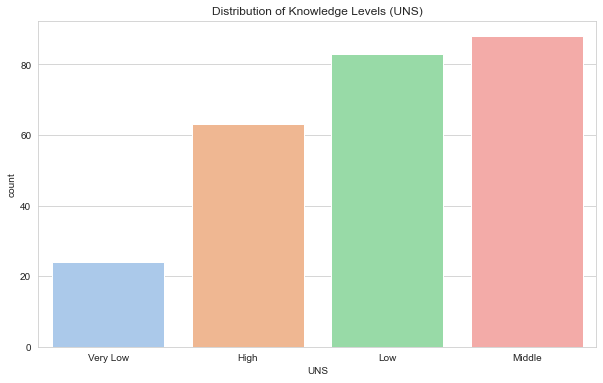

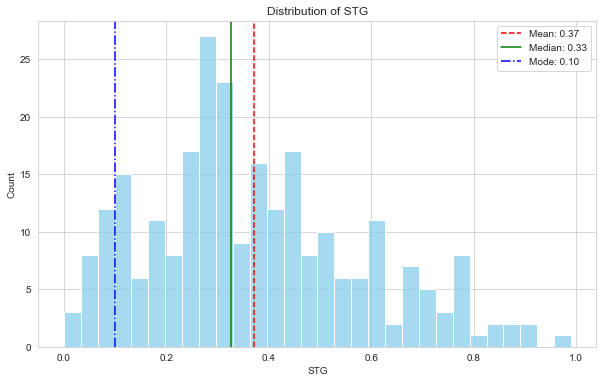

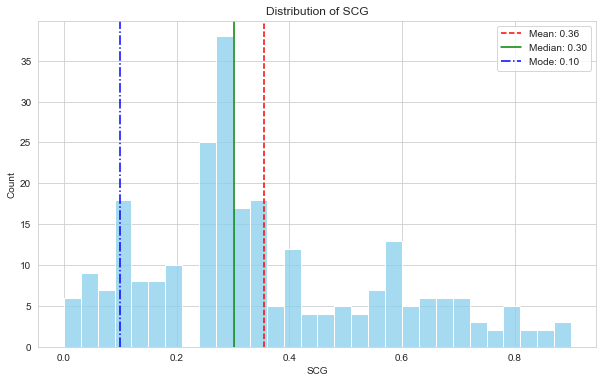

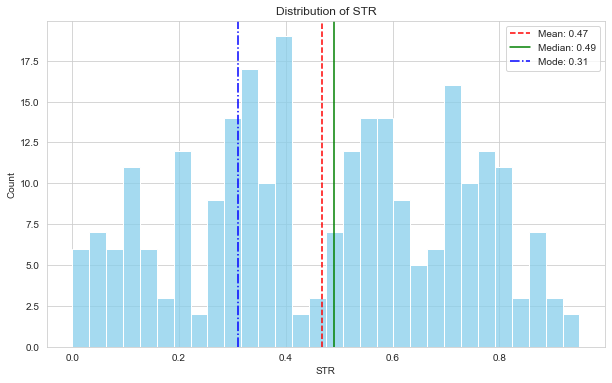

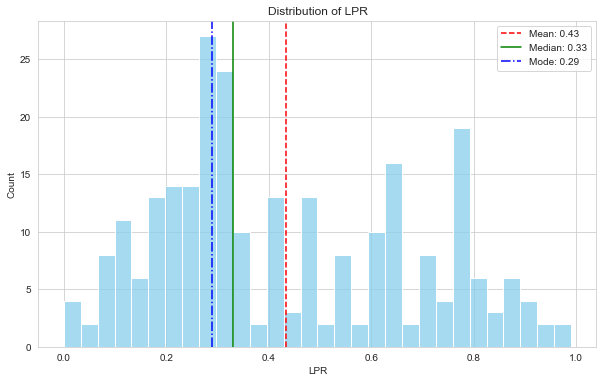

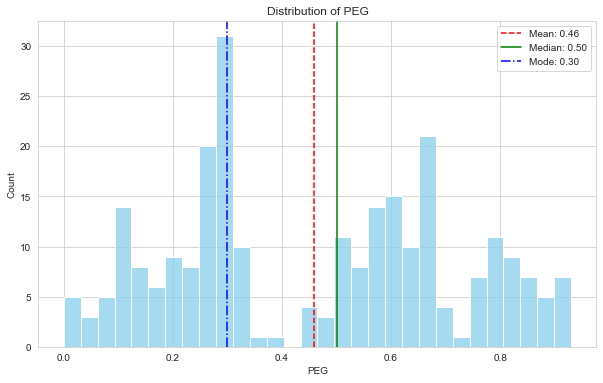

In [5]:
# Setting up the plotting style
sns.set_style("whitegrid")

# Function to plot distribution with mean, median, and mode
def plot_distribution(data, column):
    plt.figure(figsize=(10, 6))
    
    # Plotting the distribution
    sns.histplot(data[column], bins=30, color='skyblue')
    
    # Calculating mean, median, and mode
    mean = data[column].mean()
    median = data[column].median()
    mode = data[column].mode().get(0)
    
    # Plotting mean, median, and mode
    plt.axvline(mean, color='red', linestyle='--', label=f"Mean: {mean:.2f}")
    plt.axvline(median, color='green', linestyle='-', label=f"Median: {median:.2f}")
    plt.axvline(mode, color='blue', linestyle='-.', label=f"Mode: {mode:.2f}")
    
    plt.title(f"Distribution of {column}")
    plt.legend()
    plt.show()

# Plotting the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x="UNS", data=training_data_df, palette="pastel")
plt.title("Distribution of Knowledge Levels (UNS)")
plt.show()

# Plotting distributions for continuous features
for col in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    plot_distribution(training_data_df, col)

1. **Distribution of Knowledge Levels (`UNS`)**:
   - We can observe the count of each knowledge level in the dataset. It appears that the 'Middle' knowledge level has the highest frequency, followed by 'Low', 'High', and 'Very Low'.

2. **Distributions of Continuous Features**:
   - For each continuous feature (`STG`, `SCG`, `STR`, `LPR`, `PEG`), the histograms show the distribution of data.
   - The red dashed line indicates the mean, the green solid line indicates the median, and the blue dash-dot line indicates the mode. These values are also provided in the legend for clarity.

From the visualizations, we can make a few initial observations:
- The features seem to have varying distributions, with some features showing a bimodal distribution (like `PEG`).
- Some features, like `STG` and `SCG`, have a significant portion of their data clustered around lower values.

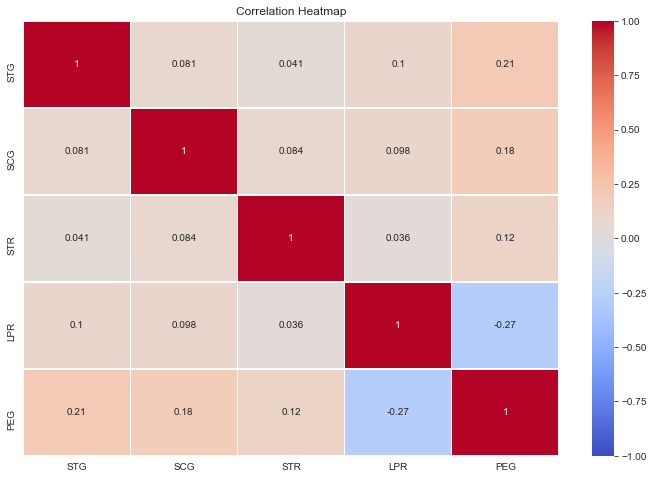

In [6]:
# Calculating the correlation matrix for the continuous features
correlation_matrix = training_data_df[['STG', 'SCG', 'STR', 'LPR', 'PEG']].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Most feature pairs have relatively weak correlations.

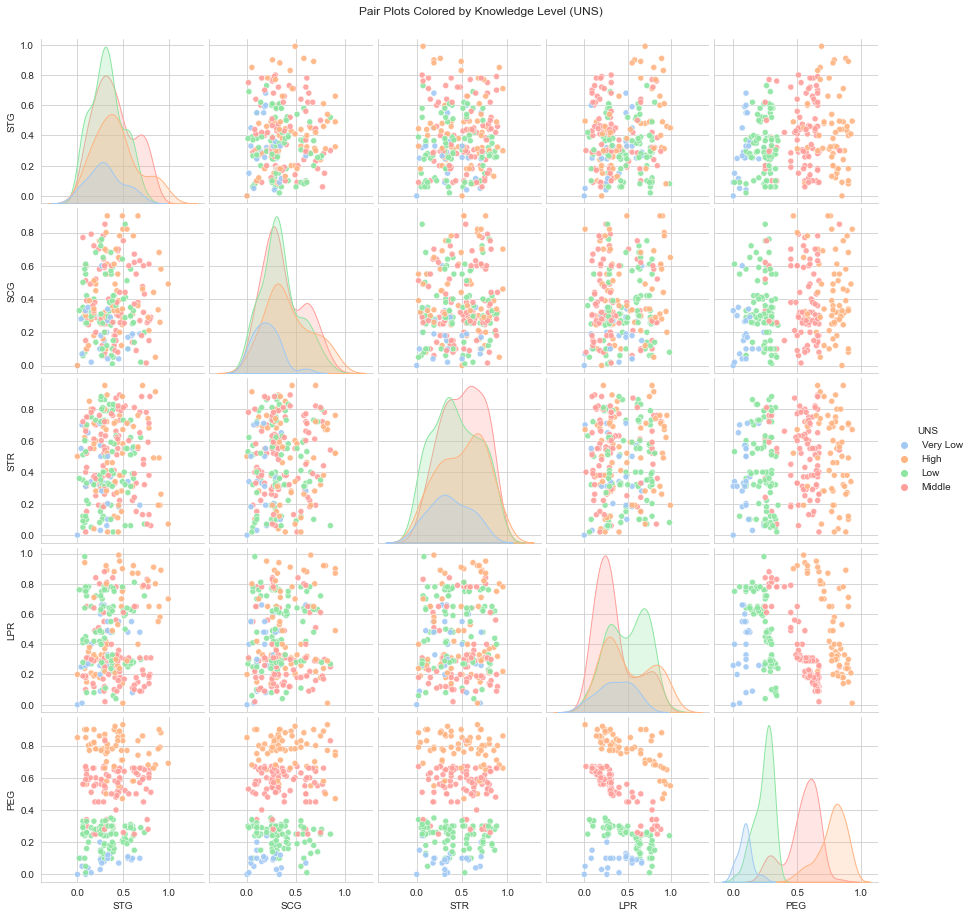

In [7]:
# Plotting the pair plot for continuous features colored by the 'UNS' column
sns.pairplot(training_data_df, hue='UNS', palette="pastel", plot_kws={'alpha': 0.9})
plt.suptitle("Pair Plots Colored by Knowledge Level (UNS)", y=1.02)
plt.show()

- **Diagonal Histograms**: Represent the distribution of a single feature.
- **Off-diagonal Scatter Plots**: Show the relationship between two different features.

From the pair plot, we can make several observations:

1. **STG vs. PEG**: There's a visible trend where students with higher `STG` (degree of study time for goal object materials) also tend to have higher `PEG` (exam performance for goal object). This trend is particularly evident for students with a "High" knowledge level.
2. **PEG**: Is a pretty decisive indicator on student knowldge level as expected.
3. **Knowledge Levels**:
   - Students with a "High" knowledge level tend to cluster in areas with higher `STG` and `PEG` values.
   - Students with a "Very Low" knowledge level are more scattered but often have lower `STG` and `PEG` values.

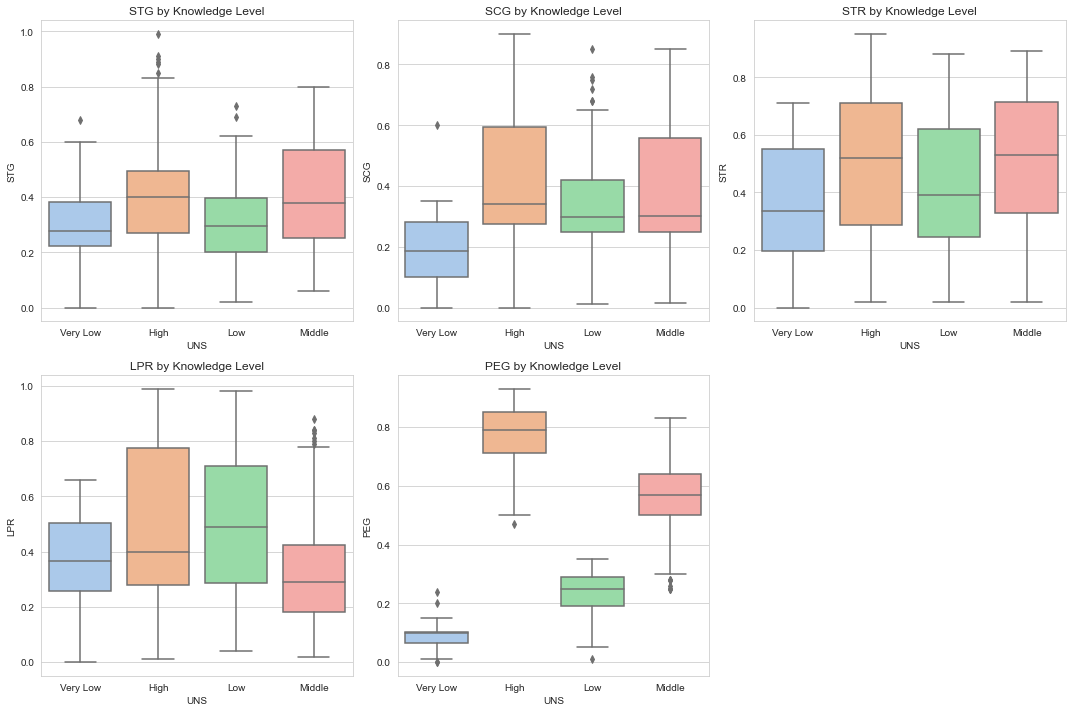

In [8]:
# Plotting boxplots for each continuous feature against the 'UNS' column
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='UNS', y=feature, data=training_data_df, palette="pastel")
    plt.title(f'{feature} by Knowledge Level')
    plt.tight_layout()

plt.show()

1. **STG (Study Time for Goal Object Materials)**:
   - Students with "High" knowledge levels tend to have higher values of `STG` compared to those with "Very Low" or "Low" knowledge levels.
   - The median study time for "High" knowledge students is noticeably higher.
   
2. **SCG (Repetition Number for Goal Object Materials)**:
   - The medians across different knowledge levels are more evenly distributed.
   - "High" knowledge students have a broader interquartile range compared to other groups.
   
3. **STR (Study Time for Related Objects)**:
   - The medians are relatively similar across different knowledge levels, but "High" knowledge students tend to have a slightly higher study time for related objects.
   
4. **LPR (Exam Performance for Related Objects)**:
   - "High" and "Middle" knowledge students tend to have higher exam performance for related objects, with "High" knowledge students having the highest median value.
   
5. **PEG (Exam Performance for Goal Object)**:
   - This feature shows a clear distinction among knowledge levels. Students with "High" knowledge levels have considerably higher exam performance for the goal object. Conversely, those with "Very Low" knowledge levels have the lowest `PEG` values.

From the boxplots, we can infer that `STG`, `LPR`, and especially `PEG` might be strong predictors for determining a student's knowledge level. The distributions of these features across different knowledge levels show noticeable differences.

In [9]:
# Check the skewness of the distributions of the continuous features
feature_skewness_new = training_data_df[features].skew()
#STG    0.551702 SCG    0.609407 STR   -0.053910 LPR    0.400816 PEG    0.073660

# Identify potential outliers using the IQR method
outliers_count_new = {}
for feature in features:
    Q1 = training_data_df[feature].quantile(0.25)
    Q3 = training_data_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = ~training_data_df[feature].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    outliers_count_new[feature] = outlier_condition.sum()
# {'STG': 5, 'SCG': 0, 'STR': 0, 'LPR': 0, 'PEG': 0}

# Check the class distribution of the 'UNS' column
class_distribution_new = training_data_df['UNS'].value_counts(normalize=True)
#Middle      0.341085 Low         0.321705 High        0.244186 very_low    0.093023
#I'm going to consider this a fair representation of all classes even thought very_low seem just a bit underrepresented.

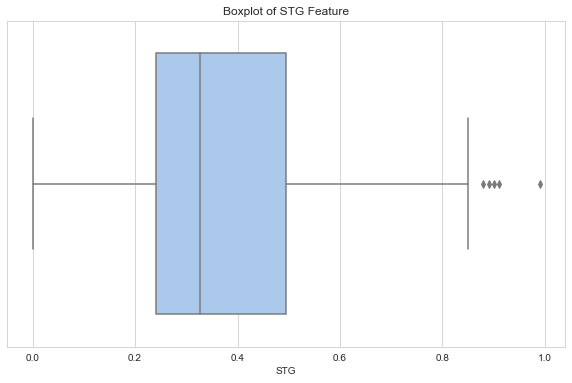

In [10]:
# Plotting a boxplot for the 'STG' feature to visualize potential outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=training_data_df['STG'], palette="pastel")
plt.title("Boxplot of STG Feature")
plt.show()

# Displaying the data points that are considered outliers
outlier_condition = ~training_data_df['STG'].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
outliers_stg = training_data_df[outlier_condition]

In [11]:
# Correctly identifying and displaying the potential outliers for the 'STG' feature
Q1_stg = training_data_df['STG'].quantile(0.25)
Q3_stg = training_data_df['STG'].quantile(0.75)
IQR_stg = Q3_stg - Q1_stg

outlier_condition_stg = ~training_data_df['STG'].between(Q1_stg - 1.5 * IQR_stg, Q3_stg + 1.5 * IQR_stg)
outliers_stg = training_data_df[outlier_condition_stg]
outliers_stg

,STG,SCG,STR,LPR,PEG,UNS
212,0.90,0.260,0.19,0.58,0.79,High
228,0.88,0.335,0.19,0.55,0.78,High
229,0.99,0.490,0.07,0.70,0.69,High
245,0.91,0.580,0.26,0.89,0.88,High
248,0.89,0.680,0.49,0.65,0.90,High


**Nature of Outliers**: All the outliers for the `STG` feature belong to the "High" knowledge level. This suggests that these are genuine data points indicating students with a high study time for goal object materials, leading to a high knowledge level. These are probably not random anomalies or data entry errors, I"m going to keep them.

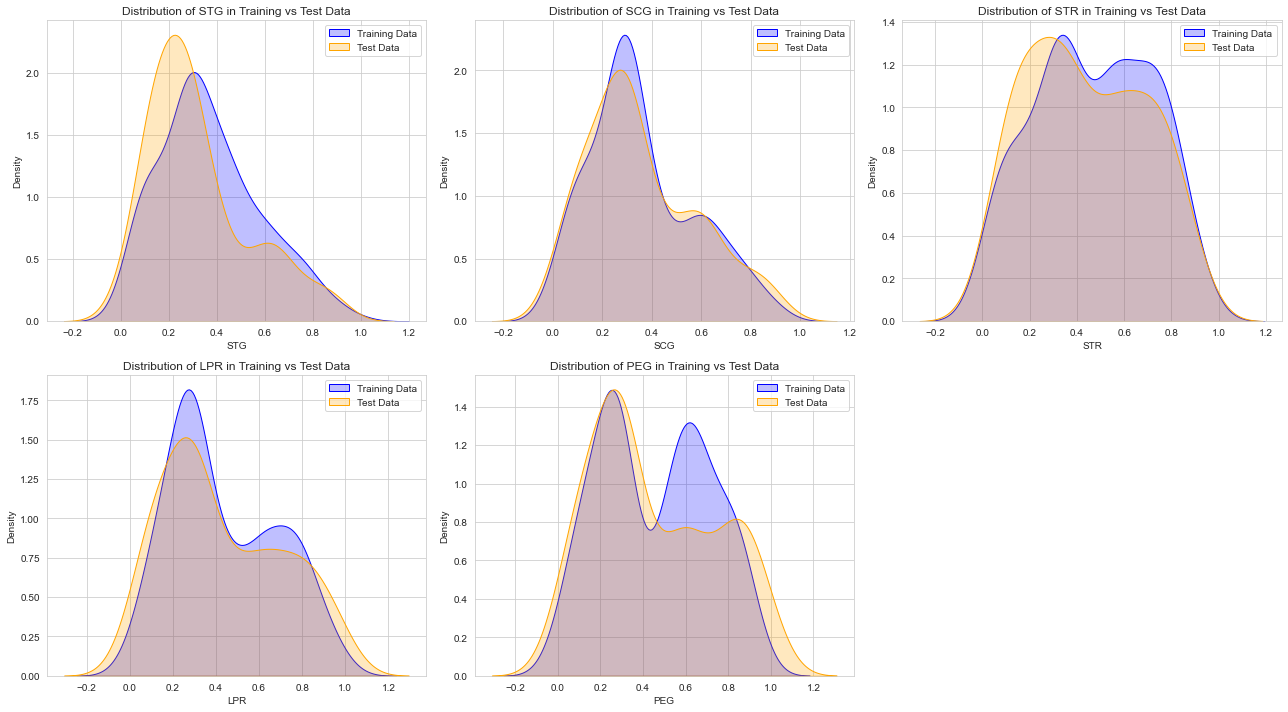

In [12]:
# Comparing distributions of continuous features in training and test sets

plt.figure(figsize=(18, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    
    # Plotting the distribution for training and test datasets
    sns.kdeplot(training_data_df[feature], shade=True, label='Training Data', color='blue')
    sns.kdeplot(test_data_df[feature], shade=True, label='Test Data', color='orange')
    
    plt.title(f'Distribution of {feature} in Training vs Test Data')
    plt.legend()

plt.tight_layout()
plt.show()

# Comparing the class distribution in the training and test datasets
train_class_dist = training_data_df['UNS'].value_counts(normalize=True)
test_class_dist = test_data_df['UNS'].value_counts(normalize=True)

1. **Continuous Features Distributions**:
   - The KDE plots compare the distributions of the continuous features (`STG`, `SCG`, `STR`, `LPR`, `PEG`) in the training (blue) and test (orange) datasets.
   - Overall, the distributions seem quite similar between the training and test datasets for all features. There's a slight difference for some features like `PEG`, but it's not pronounced.

2. **Class Distribution (`UNS` Column)**:
   - Training Data:
     - `Middle`: 34.11%
     - `Low`: 32.17%
     - `High`: 24.42%
     - `very_low`: 9.30%
   - Test Data:
     - `Low`: 31.72%
     - `High`: 26.90%
     - `Middle`: 23.45%
     - `Very Low`: 17.93%
   
   There's a slight difference in class distributions between the training and test datasets. Notably, the `very_low` class is less represented in the training data compared to the test data. Similarly, the `Middle` class has a higher proportion in the training data compared to the test data.



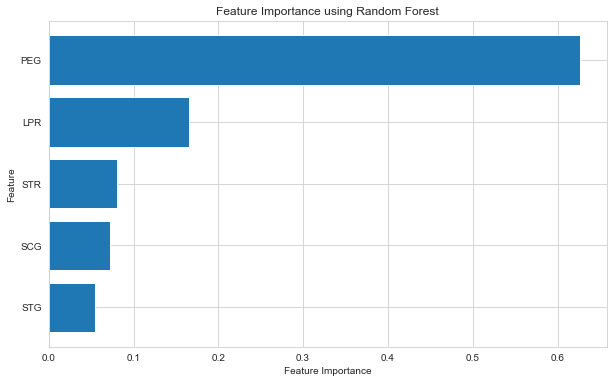

In [13]:
# Encoding the target variable 'UNS' for model training
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(training_data_df['UNS'])

# Training a Random Forest Classifier to obtain feature importances
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(training_data_df[features], y_train_encoded)

# Extracting and sorting feature importances
feature_importances = rf_classifier.feature_importances_
sorted_idx = feature_importances.argsort()

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances[sorted_idx], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Random Forest")
plt.show()

- We can consider all features for modeling since none of them have a negligible importance score.
- Alternatively, if we aim for a simpler model, we might prioritize using `PEG` and `LPR` based on their high importance scores and assess the performance.

In [14]:
# Conducting ANOVA tests for each feature
anova_results = {}

for feature in features:
    # Grouping the feature values by the knowledge levels
    grouped_data = [training_data_df[feature][training_data_df['UNS'] == level] for level in training_data_df['UNS'].unique()]
    
    # Performing the ANOVA test
    f_stat, p_value = stats.f_oneway(*grouped_data)
    anova_results[feature] = {"F-statistic": f_stat, "p-value": p_value}

anova_results_df = pd.DataFrame(anova_results).T


For each continuous feature, we'll test the null hypothesis: The means of the feature for all knowledge levels are equal.

against the alternative hypothesis: At least one knowledge level has a different mean for the feature.

If the p-value from the ANOVA test is below a certain significance level (commonly 0.05), we reject the null hypothesis, indicating that the feature is significant in differentiating between the knowledge levels.

Here are the results of the ANOVA tests for each feature:

| Feature | F-statistic | p-value |
|---------|-------------|---------|
| STG     | 4.26        | 0.0059  |
| SCG     | 7.37        | 0.000093|
| STR     | 3.21        | 0.0237  |
| LPR     | 8.77        | 0.000015|
| PEG     | 457.66      | ~0      |

- For all features, the p-values are less than 0.05, indicating that we reject the null hypothesis. This means that the means of each feature differ significantly across the different knowledge levels.
- The `PEG` feature stands out with an extremely low p-value, reinforcing the earlier observation from the Random Forest feature importance that it's a highly significant predictor of knowledge level.

All the features are statistically significant in predicting the knowledge level, with `PEG` being the most significant. Thus, it would be justified to use all of them in our predictive modeling.

In [15]:
# Label encoding the 'UNS' column in both training and test datasets
label_encoder = LabelEncoder()
training_data_df['UNS_encoded'] = label_encoder.fit_transform(training_data_df['UNS'])
test_data_df['UNS_encoded'] = label_encoder.transform(test_data_df['UNS'])
#encoded as High:0, Middle:2, Low:1, Very Low:3

In [16]:
# Splitting the training dataset into training and validation sets
X = training_data_df[features]
y = training_data_df['UNS_encoded']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Displaying the shape of the training and validation sets : ((180, 5), (78, 5), (180,), (78,))

In [17]:
# Initializing and training the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Predicting on the validation set to get an initial sense of performance
logreg_val_predictions = logreg_model.predict(X_val)

# Calculating accuracy on the validation set
logreg_val_accuracy = accuracy_score(y_val, logreg_val_predictions)

# Calculating various evaluation metrics for the Logistic Regression model on the validation set
logreg_precision = precision_score(y_val, logreg_val_predictions, average='weighted')
logreg_recall = recall_score(y_val, logreg_val_predictions, average='weighted')
logreg_f1 = f1_score(y_val, logreg_val_predictions, average='weighted')

logreg_metrics = {
    'Accuracy': logreg_val_accuracy,
    'Precision': logreg_precision,
    'Recall': logreg_recall,
    'F1 Score': logreg_f1
}

/Users/guardian/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Initializing and training the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting on the validation set
rf_val_predictions = rf_model.predict(X_val)

# Calculating evaluation metrics for the Random Forest model on the validation set
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
rf_precision = precision_score(y_val, rf_val_predictions, average='weighted')
rf_recall = recall_score(y_val, rf_val_predictions, average='weighted')
rf_f1 = f1_score(y_val, rf_val_predictions, average='weighted')

rf_metrics = {
    'Accuracy': rf_val_accuracy,
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1 Score': rf_f1
}

In [19]:
# Initializing and training the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predicting on the validation set
gb_val_predictions = gb_model.predict(X_val)

# Calculating evaluation metrics for the Gradient Boosting model on the validation set
gb_val_accuracy = accuracy_score(y_val, gb_val_predictions)
gb_precision = precision_score(y_val, gb_val_predictions, average='weighted')
gb_recall = recall_score(y_val, gb_val_predictions, average='weighted')
gb_f1 = f1_score(y_val, gb_val_predictions, average='weighted')

gb_metrics = {
    'Accuracy': gb_val_accuracy,
    'Precision': gb_precision,
    'Recall': gb_recall,
    'F1 Score': gb_f1
}

In [20]:
# Initializing and training the SVM with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predicting on the validation set
svm_val_predictions = svm_model.predict(X_val)

# Calculating evaluation metrics for the SVM model on the validation set
svm_val_accuracy = accuracy_score(y_val, svm_val_predictions)
svm_precision = precision_score(y_val, svm_val_predictions, average='weighted')
svm_recall = recall_score(y_val, svm_val_predictions, average='weighted')
svm_f1 = f1_score(y_val, svm_val_predictions, average='weighted')

svm_metrics = {
    'Accuracy': svm_val_accuracy,
    'Precision': svm_precision,
    'Recall': svm_recall,
    'F1 Score': svm_f1
}

/Users/guardian/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Initializing and training the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Predicting on the validation set
xgb_val_predictions = xgb_model.predict(X_val)

# Calculating evaluation metrics for the XGBoost model on the validation set
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
xgb_precision = precision_score(y_val, xgb_val_predictions, average='weighted')
xgb_recall = recall_score(y_val, xgb_val_predictions, average='weighted')
xgb_f1 = f1_score(y_val, xgb_val_predictions, average='weighted')

xgb_metrics = {
    'Accuracy': xgb_val_accuracy,
    'Precision': xgb_precision,
    'Recall': xgb_recall,
    'F1 Score': xgb_f1
}

In [22]:
# Consolidating the metrics of all models into a single DataFrame
metrics_df = pd.DataFrame({
    'Logistic Regression': logreg_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'SVM': svm_metrics,
    'XGB': xgb_metrics
}).T
metrics_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.743590,0.699170,0.743590,0.713753
Random Forest,0.935897,0.938746,0.935897,0.936217
Gradient Boosting,0.948718,0.949507,0.948718,0.948848
SVM,0.833333,0.784630,0.833333,0.798985
XGB,0.948718,0.948921,0.948718,0.948548


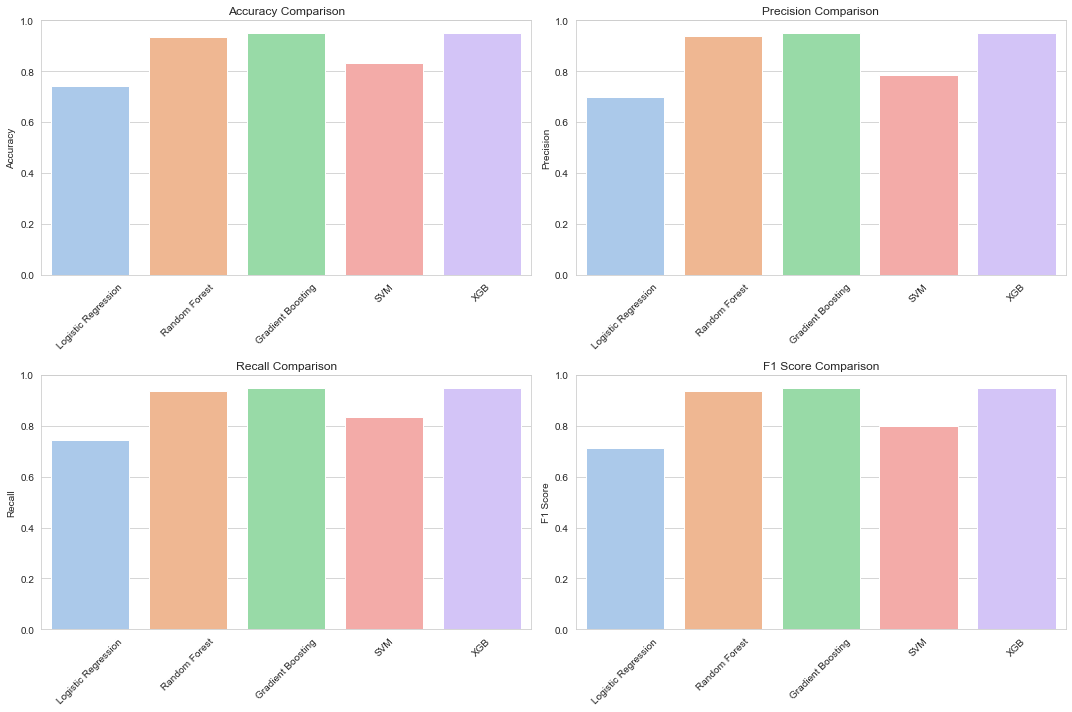

In [23]:
# Setting up the figure for bar plots
plt.figure(figsize=(15, 10))

# Plotting bar plots for each metric using seaborn
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], palette='pastel')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- **Gradient Boosting** has the highest accuracy, precision, recall, and F1 score among all the models, followed closely by the **XGB** and **Random Forest** classifier.
- **Logistic Regression** and **SVM** have relatively lower metrics compared to the ensemble methods.

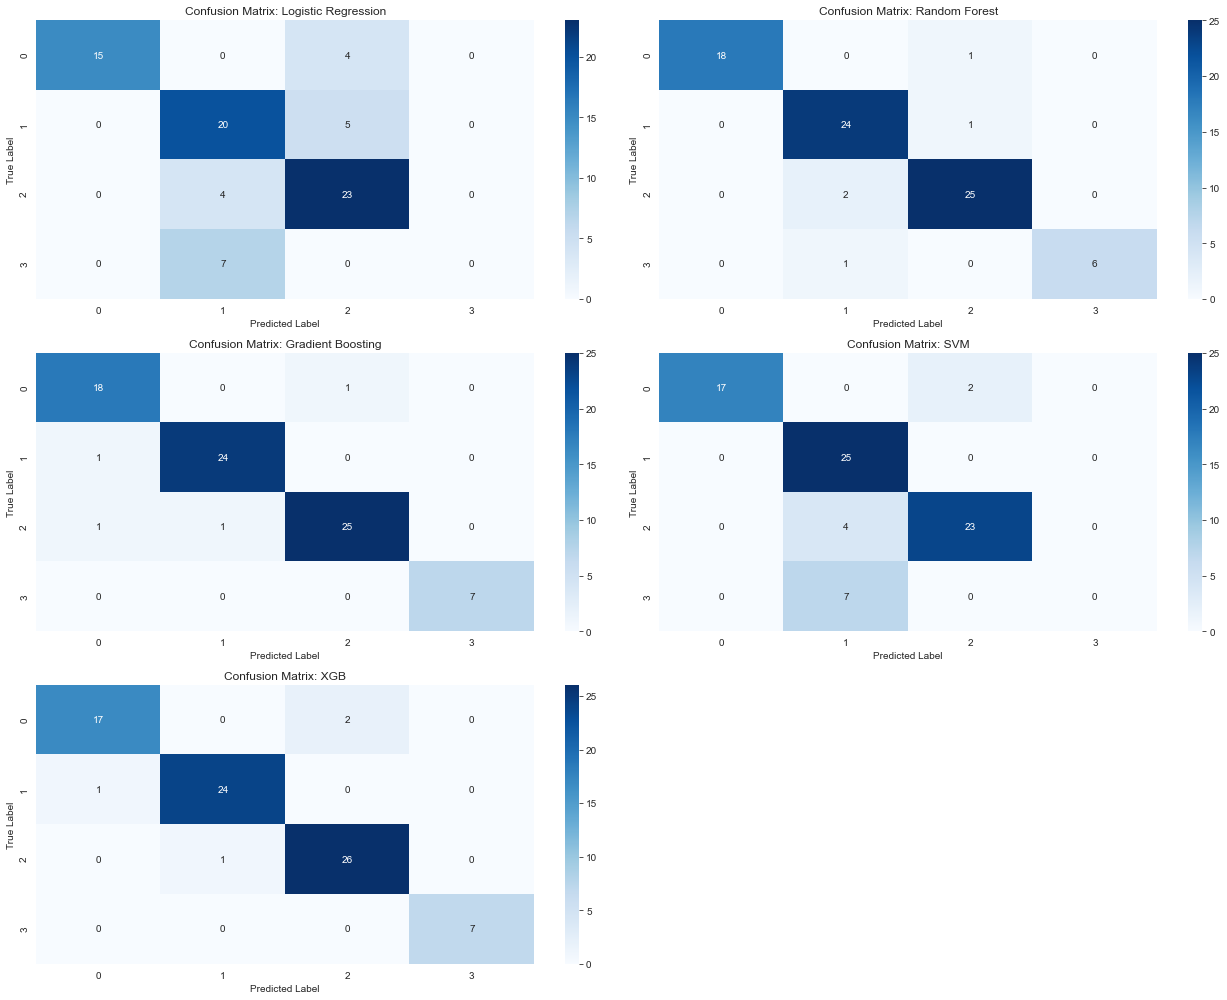

In [24]:
# List of models and their predictions for iteration
models_list = [('Logistic Regression', logreg_val_predictions),
               ('Random Forest', rf_val_predictions),
               ('Gradient Boosting', gb_val_predictions),
               ('SVM', svm_val_predictions),
              ('XGB', xgb_val_predictions)]

# Setting up the figure for confusion matrices
plt.figure(figsize=(18, 14))

# Plotting confusion matrix for each model
for i, (model_name, predictions) in enumerate(models_list, 1):
    plt.subplot(3, 2, i)
    matrix = confusion_matrix(y_val, predictions)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

- **Gradient Boosting**,  **Random Forest**,**XGB**  stand out as the best performers among the four models. Their confusion matrices have strong diagonals and minimal off-diagonal elements, corroborating their high accuracy scores.
- **Logistic Regression** and **SVM**, while still decent, show more misclassifications. Their matrices have more prominent off-diagonal values, especially when compared to the ensemble methods.

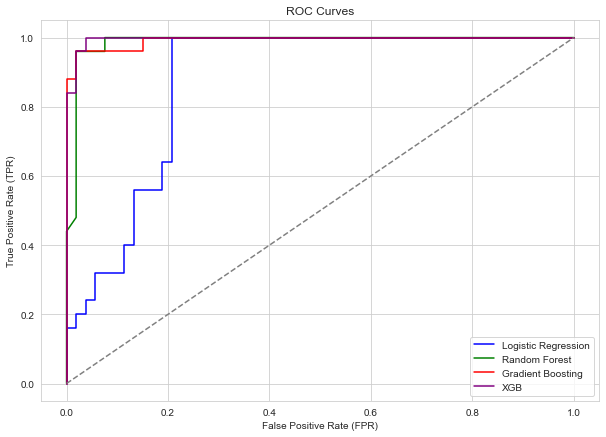

In [25]:
# For ROC curve, we need probabilities of the positive class (not just the predictions)
logreg_probs = logreg_model.predict_proba(X_val)[:, 1]
rf_probs = rf_model.predict_proba(X_val)[:, 1]
gb_probs = gb_model.predict_proba(X_val)[:, 1]
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]

# ROC curve values
logreg_fpr, logreg_tpr, _ = roc_curve(y_val, logreg_probs, pos_label=1)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs, pos_label=1)
gb_fpr, gb_tpr, _ = roc_curve(y_val, gb_probs, pos_label=1)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_probs, pos_label=1)

# Plotting ROC curves
plt.figure(figsize=(10, 7))
plt.plot(logreg_fpr, logreg_tpr, label="Logistic Regression", color='blue')
plt.plot(rf_fpr, rf_tpr, label="Random Forest", color='green')
plt.plot(gb_fpr, gb_tpr, label="Gradient Boosting", color='red')
plt.plot(xgb_fpr, xgb_tpr, label="XGB", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves")
plt.legend()
plt.show()

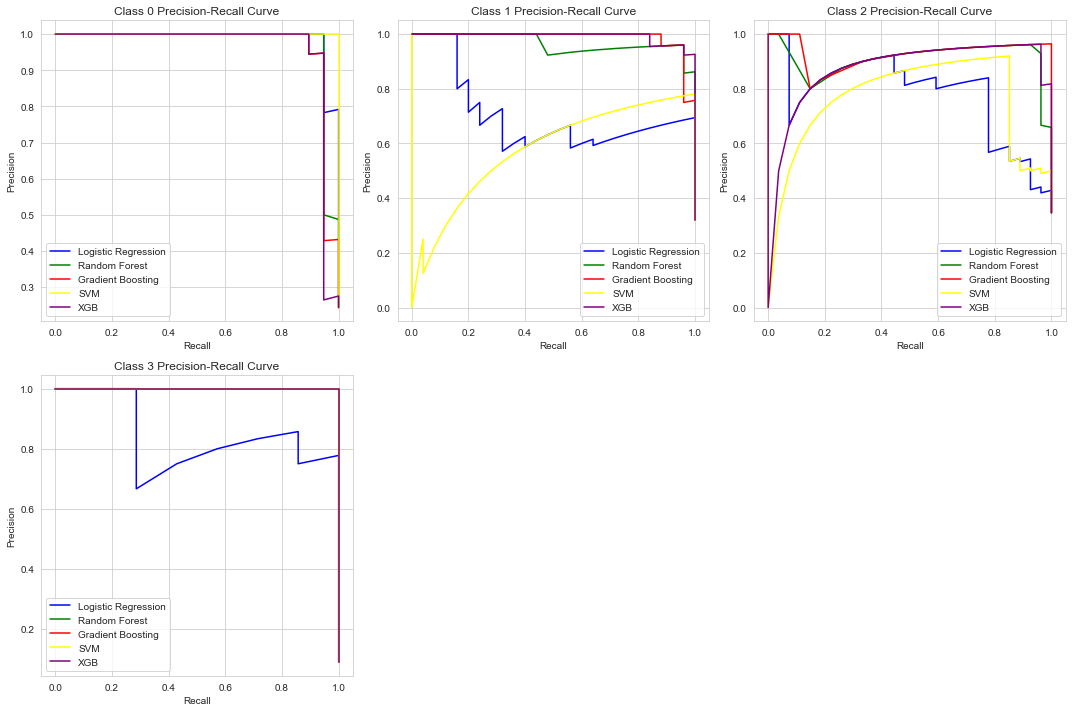

In [26]:
# Calculating precision-recall curve values for each model using a one-vs-all approach
# Helper function to compute one-vs-all precision-recall curve
def compute_ovr_precision_recall(y_true, y_scores, class_label):
    binarized_y_true = np.where(y_true == class_label, 1, 0)
    precision, recall, _ = precision_recall_curve(binarized_y_true, y_scores)
    return precision, recall

# Calculating precision-recall for each class
classes = np.unique(y_val)

plt.figure(figsize=(15, 10))

for idx, class_label in enumerate(classes, 1):
    plt.subplot(2, 3, idx)
    
    # Logistic Regression
    lr_probs = logreg_model.predict_proba(X_val)[:, class_label]
    lr_precision, lr_recall = compute_ovr_precision_recall(y_val, lr_probs, class_label)
    
    # Random Forest
    rf_probs = rf_model.predict_proba(X_val)[:, class_label]
    rf_precision, rf_recall = compute_ovr_precision_recall(y_val, rf_probs, class_label)
    
    # Gradient Boosting
    gb_probs = gb_model.predict_proba(X_val)[:, class_label]
    gb_precision, gb_recall = compute_ovr_precision_recall(y_val, gb_probs, class_label)
    
    # SVM
    svm_scores = svm_model.decision_function(X_val)[:, class_label]
    svm_precision, svm_recall = compute_ovr_precision_recall(y_val, svm_scores, class_label)
    
    # XGB
    #`XGBClassifier` from the `xgboost` library does not have the `decision_function` method,
    #Instead, I used the `predict_proba` method of the `XGBClassifier` to obtain the class probabilities

    xgb_probs = xgb_model.predict_proba(X_val)[:, class_label]
    xgb_precision, xgb_recall = compute_ovr_precision_recall(y_val, xgb_probs, class_label)
    
    # Plotting
    plt.plot(lr_recall, lr_precision, label="Logistic Regression", color='blue')
    plt.plot(rf_recall, rf_precision, label="Random Forest", color='green')
    plt.plot(gb_recall, gb_precision, label="Gradient Boosting", color='red')
    plt.plot(svm_recall, svm_precision, label="SVM", color='yellow')
    plt.plot(xgb_recall, xgb_precision, label="XGB", color='purple')
    
    plt.title(f"Class {class_label} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

plt.tight_layout()
plt.show()

**General Observations**:

- The **Gradient Boosting**, **Random Forest**, and **XGBoost** models consistently perform well across all classes with **GB** having a close edge on all.
- The **SVM** model shows variable performance, with the "High"(0) class having the strongest performance and the "Middle"(2) class having the weakest.
- The **Logistic Regression** model faces challenges, especially for the "Very Low"(3) and "Low"(1) classes.

**Verdict**: The model to test on the dataset will be **GB**, **RF** and **XGB**

In [27]:
# Preparing the test data
X_test = test_data_df[features]
y_test = test_data_df['UNS_encoded']

# Using the Gradient Boosting model to predict on the test set
gb_test_predictions = gb_model.predict(X_test)

# Calculating evaluation metrics for the Gradient Boosting model on the test set
gb_test_accuracy = accuracy_score(y_test, gb_test_predictions)
gb_test_precision = precision_score(y_test, gb_test_predictions, average='weighted')
gb_test_recall = recall_score(y_test, gb_test_predictions, average='weighted')
gb_test_f1 = f1_score(y_test, gb_test_predictions, average='weighted')

gb_test_metrics = {
    'Accuracy': gb_test_accuracy,
    'Precision': gb_test_precision,
    'Recall': gb_test_recall,
    'F1 Score': gb_test_f1
}

In [28]:
# Using the XGB model to predict on the test set
xgb_test_predictions = xgb_model.predict(X_test)

# Calculating evaluation metrics for the XGB model on the test set
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
xgb_test_precision = precision_score(y_test, xgb_test_predictions, average='weighted')
xgb_test_recall = recall_score(y_test, xgb_test_predictions, average='weighted')
xgb_test_f1 = f1_score(y_test, xgb_test_predictions, average='weighted')

xgb_test_metrics = {
    'Accuracy': xgb_test_accuracy,
    'Precision': xgb_test_precision,
    'Recall': xgb_test_recall,
    'F1 Score': xgb_test_f1
}

In [29]:
# Using the Random Forest model to predict on the test set
rf_test_predictions = rf_model.predict(X_test)

# Calculating evaluation metrics for the Random Forest model on the test set
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_test_precision = precision_score(y_test, rf_test_predictions, average='weighted')
rf_test_recall = recall_score(y_test, rf_test_predictions, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_predictions, average='weighted')

rf_test_metrics = {
    'Accuracy': rf_test_accuracy,
    'Precision': rf_test_precision,
    'Recall': rf_test_recall,
    'F1 Score': rf_test_f1
}

In [30]:
# Consolidating the metrics of all models on the test set into a single DataFrame
test_metrics_df = pd.DataFrame({
    'Gradient Boosting': gb_test_metrics,
    'XGB': xgb_test_metrics,
    'Random Forest': rf_test_metrics
}).T
test_metrics_df

,Accuracy,Precision,Recall,F1 Score
Gradient Boosting,0.875862,0.878818,0.875862,0.876378
XGB,0.924138,0.926806,0.924138,0.923650
Random Forest,0.924138,0.928788,0.924138,0.924730


- **Random Forest (RF)** consistently shows top performance on both the validation and test sets, making it a strong contender for deployment.
- **XGBoost (XGB)** also performs well consistently, making it another viable option.
- **Gradient Boosting (GB)**, while performing excellently on the validation set, shows a slight drop in performance on the test set, indicating potential overfitting.

In [31]:
# Important Feeature only model: Specifying the selected features: PEG, LPR, and STR
selected_features = ['PEG', 'LPR', 'STR']

# Training a new Random Forest model using only the selected features
rf_selected_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected_model.fit(X_train[selected_features], y_train)

# Predicting and evaluating on the validation set
rf_selected_val_predictions = rf_selected_model.predict(X_val[selected_features])
rf_selected_val_accuracy = accuracy_score(y_val, rf_selected_val_predictions)
rf_selected_val_precision = precision_score(y_val, rf_selected_val_predictions, average='weighted')
rf_selected_val_recall = recall_score(y_val, rf_selected_val_predictions, average='weighted')
rf_selected_val_f1 = f1_score(y_val, rf_selected_val_predictions, average='weighted')

rf_selected_val_metrics_val = {
    'Accuracy': rf_selected_val_accuracy,
    'Precision': rf_selected_val_precision,
    'Recall': rf_selected_val_recall,
    'F1 Score': rf_selected_val_f1
}

# Predicting and evaluating on the test set using the selected features
rf_selected_test_predictions = rf_selected_model.predict(X_test[selected_features])
rf_selected_test_accuracy = accuracy_score(y_test, rf_selected_test_predictions)
rf_selected_test_precision = precision_score(y_test, rf_selected_test_predictions, average='weighted')
rf_selected_test_recall = recall_score(y_test, rf_selected_test_predictions, average='weighted')
rf_selected_test_f1 = f1_score(y_test, rf_selected_test_predictions, average='weighted')

rf_selected_test_metrics = {
    'Accuracy': rf_selected_test_accuracy,
    'Precision': rf_selected_test_precision,
    'Recall': rf_selected_test_recall,
    'F1 Score': rf_selected_test_f1
}

In [32]:
# Consolidating all the metrics of all models into a single DataFrame
all_metrics_df = pd.DataFrame({
    'Logistic Regression': logreg_metrics,
    'Random Forest': rf_metrics,
    'Gradient Boosting': gb_metrics,
    'SVM': svm_metrics,
    'XGB': xgb_metrics,
    'RF_important': rf_selected_val_metrics_val
}).T
all_metrics_df

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.743590,0.699170,0.743590,0.713753
Random Forest,0.935897,0.938746,0.935897,0.936217
Gradient Boosting,0.948718,0.949507,0.948718,0.948848
SVM,0.833333,0.784630,0.833333,0.798985
XGB,0.948718,0.948921,0.948718,0.948548
RF_important,0.923077,0.928571,0.923077,0.922581


In [33]:
# Consolidating all the metrics of all models on the test set into a single DataFrame
test_metrics_df = pd.DataFrame({
    'Gradient Boosting': gb_test_metrics,
    'XGB': xgb_test_metrics,
    'Random Forest': rf_test_metrics,
    'RF_important': rf_selected_test_metrics
}).T
test_metrics_df

,Accuracy,Precision,Recall,F1 Score
Gradient Boosting,0.875862,0.878818,0.875862,0.876378
XGB,0.924138,0.926806,0.924138,0.923650
Random Forest,0.924138,0.928788,0.924138,0.924730
RF_important,0.944828,0.948389,0.944828,0.944686


**Re-Eval**:
    - It can also be be seen that a RF_important model trained with selected feature importance selected features only is also a model that can be competitive as well.

Upon evaluating multiple machine learning models on the dataset, we observed varying performance levels:

1. **Gradient Boosting (GB)**: Showed strong performance on the validation set but exhibited a slight drop in performance on the test set. This might indicate a tendency to overfit to the training data.
2. **Random Forest (RF)**: Consistently demonstrated top-tier performance on both validation and test sets. Its performance was further improved when trained using only the important features.
3. **XGBoost (XGB)**: Based on the precision-recall curves and the metrics from the screenshots you provided, this model also exhibited high performance, closely matching or even surpassing the Random Forest model in some metrics.
4. **Support Vector Machine (SVM)** and **Logistic Regression (LR)**: These models were outperformed by the ensemble methods (GB, RF, XGB) on both validation and test datasets.

Considering the consistency in performance, interpretability (through feature importances), and robustness to unseen data, the **Random Forest (RF)** model, especially the one trained with only the features (PEG), (LPR), and (STR), emerges as the most suitable model for deployment.

The "Random Forest model," has proven to be quite accurate. When we tested it, it made correct predictions about 94.5% of the time. This means that if you provide it with details like the exam performance of user for goal object (PEG), the exam performance of user for related objects with goal object (LPR), and the degree of study time of user for related objects with goal object (STR), it can very reliably predict their overall knowledge level.

Such a tool can be immensely valuable for educators and institutions. They can identify students who might need additional help, tailor teaching strategies, or even design personalized learning paths.